# Check the structure function and cross-section values

In [1]:
using Pkg

# Uncomment below to update PartonDensity/BAT!
#Pkg.rm("BAT")
#Pkg.add(url="https://github.com/bat/BAT.jl.git", rev="main")
#Pkg.rm("PartonDensity")
#Pkg.add(url="https://github.com/cescalara/PartonDensity.jl.git")

Pkg.instantiate()

┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/fran/projects/high-x-parton-pdf-inference/Manifest.toml:0


In [2]:
using PartonDensity, QCDNUM
using BAT, StatsBase, NaNMath
using Plots, DataFrames

Load results

In [3]:
# Results
samples = bat_read("Data-Dirichlet-Kqfree.h5").result;
samples_mode = mode(samples)

# As in PDF-fit-dirichlet.ipynb
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, 
                         spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();

In [4]:
weights = [3.0, 1.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.5, 0.5]
pdf_params = DirichletPDFParams(K_u=4.0, K_d=6.0, λ_g1=0.7, λ_g2=-0.4,
    K_g=6.0, λ_q=-0.5, K_q=5, seed=5, weights=weights);

Define PDF

In [5]:
samples_mode.K_u

3.85991803044647

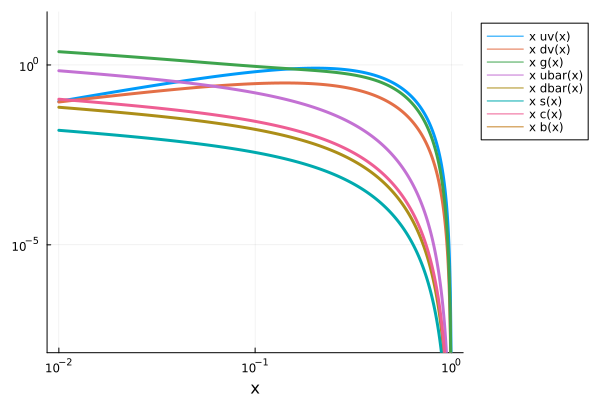

In [6]:
pdf_params = DirichletPDFParams(K_u=samples_mode.K_u, K_d=samples_mode.K_d, λ_g1=samples_mode.λ_g1, 
λ_g2=samples_mode.λ_g2, K_g=samples_mode.K_g, λ_q=samples_mode.λ_q, K_q=samples_mode.K_q, θ=samples_mode.θ)

plot_input_pdfs(pdf_params)

Evolve with QCDNUM

In [7]:
QCDNUM.qcinit(-6, "")
QCDNUM.setord(qcdnum_params.order)
QCDNUM.setalf(qcdnum_params.α_S, qcdnum_params.q0)

  +---------------------------------------------------------------------+   
  |                                                                     |   
  |    If you use QCDNUM, please refer to:                              |   
  |                                                                     |   
  |    M. Botje, Comput. Phys. Commun. 182(2011)490, arXiV:1005.1481    |   
  |                                                                     |   
  +---------------------------------------------------------------------+   


In [8]:
g = qcdnum_params.grid
QCDNUM.gxmake(g.x_min, g.x_weights, g.x_num_bounds, g.nx,
    g.spline_interp);
QCDNUM.gqmake(g.qq_bounds, g.qq_weights, g.qq_num_bounds, g.nq);

QCDNUM.setcbt(qcdnum_params.n_fixed_flav, qcdnum_params.iqc,
    qcdnum_params.iqb, qcdnum_params.iqt);

nw = QCDNUM.fillwt(qcdnum_params.weight_type)
nw = QCDNUM.zmfillw()

my_func = get_input_pdf_func(pdf_params)
input_pdf = @cfunction(my_func, Float64, (Ref{Int32}, Ref{Float64}))

iq0 = QCDNUM.iqfrmq(qcdnum_params.q0)
pdf_loc = 1
eps = QCDNUM.evolfg(pdf_loc, input_pdf, input_pdf_map, iq0)

  
  

 FILLWT: start unpolarised weight calculations
 Subgrids    3 Subgrid points   15   50   75
 Pij LO
 Pij NLO
 Pij NNLO
 Aij LO
 Aij NLO
 Aij NNLO
 FILLWT: weight calculations completed


 ZMFILLW: start weight calculations   4  38   0   0
 ZMFILLW: calculations completed


0.0031176224658473577

Make splines

In [9]:
if !PartonDensity.splint_init_complete
    QCDNUM.ssp_spinit(splint_params.nuser)
end
ia = QCDNUM.isp_s2make(splint_params.nsteps_x, splint_params.nsteps_q);
xnd = QCDNUM.ssp_unodes(ia, splint_params.nnodes_x, 0);
qnd = QCDNUM.ssp_vnodes(ia, splint_params.nnodes_q, 0);

QCDNUM.ssp_nprint(ia);
QCDNUM.ssp_erase(ia);

iaFLup = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaFLup, pdf_loc, quark_coeffs.proup, 1, 0.0);

iaF2up = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaF2up, pdf_loc, quark_coeffs.proup, 2, 0.0);

iaF3up = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaF3up, pdf_loc, quark_coeffs.valup, 3, 0.0);

iaFLdn = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaFLdn, pdf_loc, quark_coeffs.prodn, 1, 0.0);

iaF2dn = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaF2dn, pdf_loc, quark_coeffs.prodn, 2, 0.0);

iaF3dn = QCDNUM.isp_s2user(xnd, splint_params.nnodes_x, qnd, splint_params.nnodes_q);
QCDNUM.ssp_s2f123(iaF3dn, 1, quark_coeffs.valdn, 3, 0.0);

QCDNUM.ssp_uwrite(splint_params.spline_addresses.F2up, Float64(iaF2up));
QCDNUM.ssp_uwrite(splint_params.spline_addresses.F2dn, Float64(iaF2dn));
QCDNUM.ssp_uwrite(splint_params.spline_addresses.F3up, Float64(iaF3up));
QCDNUM.ssp_uwrite(splint_params.spline_addresses.F3dn, Float64(iaF3dn));
QCDNUM.ssp_uwrite(splint_params.spline_addresses.FLup, Float64(iaFLup));
QCDNUM.ssp_uwrite(splint_params.spline_addresses.FLdn, Float64(iaFLdn));

my_func = get_input_xsec_func()
input_xsec = @cfunction(my_func, Float64, (Ref{Int32}, Ref{Int32}, Ref{UInt8}))


  +---------------------------------------+
  | You are using SPLINT version 20220308 |
  +---------------------------------------+



  N   IX     XNODE    NQMA      IQ     QNODE    NXMI
  1    1  0.10000E-02    0       1  0.10000E+03    0
  2    5  0.14454E-02    0       2  0.11234E+03    0
  3   10  0.22909E-02    0      12  0.35982E+03    0
  4   15  0.36308E-02    0      22  0.11525E+04    0
  5   20  0.57544E-02    0      32  0.36911E+04    0
  6   25  0.91201E-02    0      42  0.11822E+05    0
  7   30  0.14454E-01    0      50  0.30000E+05    0
  8   35  0.22909E-01    0       -       -         -
  9   40  0.36308E-01    0       -       -         -
 10   45  0.57544E-01    0       -       -         -
 11   50  0.91201E-01    0       -       -         -
 12   55  0.12023E+00    0       -       -         -
 13   60  0.15136E+00    0       -       -         -
 14   65  0.19055E+00    0       -       -         -
 15   70  0.23988E+00    0       -       -         -
 16   75  0.3020

Ptr{Nothing} @0x00000001169b8f20

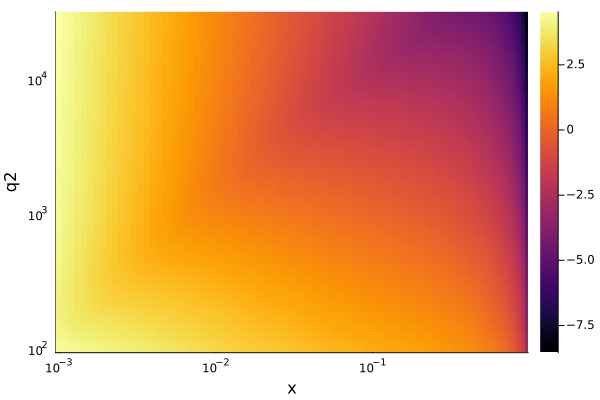

In [10]:
xsec_on_grid = zeros(g.nx, g.nq);

for ix = 1:g.nx
    for iq = 1:g.nq
        xsec_on_grid[ix, iq] = _fun_xsec_i(ix, iq)
    end
end

qcdnum_x_grid = QCDNUM.gxcopy(g.nx)
qcdnum_qq_grid = QCDNUM.gqcopy(g.nq)
p1 = heatmap(qcdnum_x_grid, qcdnum_qq_grid, NaNMath.log10.(xsec_on_grid[:, :]'))
plot(p1, xlabel="x", ylabel="q2",
    xaxis=:log, yaxis=:log)

Find xsec values at bin centres

In [11]:
nbins = 153
q2_bin_cens = Any[]
x_bin_cens = Any[]
for i in 1:nbins
    (q2_edges, x_edges) = get_bin_info(i, quiet=true);
    push!(q2_bin_cens, mean(q2_edges))
    push!(x_bin_cens, mean(x_edges))
end

In [12]:
xsec_in_bins = zeros(nbins)
F2_in_bins = zeros(nbins)

ZMass = 91.1876
WMass = 80.398
AlphaEM = 7.297352570e-03
GFermi = 1.16637e-05
TopMass = 171.2
BottomMass = 4.20

Vub = 41.2e-3
Vcb = 3.93e-3

Sin2ThetaW = 0.23127
Sin2ThetaC = 0.05
vu = 0.19164
vd = -0.34582
ve = -0.03746

au = 0.5
ad = -0.5
ae = -0.5

for i = 1:nbins
        ix = QCDNUM.ixfrmx(x_bin_cens[i])
        iq = QCDNUM.iqfrmq(q2_bin_cens[i])
        xsec_in_bins[i] = _fun_xsec_i(ix, iq)
        
        iF2up = Int32(QCDNUM.dsp_uread(1))
        iF2dn = Int32(QCDNUM.dsp_uread(2))
        pz = q2_bin_cens[i] / ((ZMass * ZMass + q2_bin_cens[i]) * (4 * (Sin2ThetaW) * (1 - Sin2ThetaW)))
        Au = 4.0 / 9.0 - 2 * pz * (2.0 / 3.0) * (vu) * (ve) + pz * pz * (ve * ve + ae * ae) * (vu * vu + au * au)
        Ad = 1.0 / 9.0 - 2 * pz * (-1.0 / 3.0) * (vd) * (ve) + pz * pz * (ve * ve + ae * ae) * (vd * vd + ad * ad)
        F2_in_bins[i] = Au * QCDNUM.dsp_funs2(iF2up, x_bin_cens[i], q2_bin_cens[i], 1) + Ad * QCDNUM.dsp_funs2(iF2dn, x_bin_cens[i], q2_bin_cens[i], 1)
end

Write to file

In [13]:
data_frame = DataFrame(x_bin_cens=x_bin_cens, q2_bin_cens=q2_bin_cens, diff_xsec=xsec_in_bins, F2=F2_in_bins)

Row,x_bin_cens,q2_bin_cens,diff_xsec,F2
,Any,Any,Float64,Float64
1,0.062,725.0,3.95664,0.515791
2,0.079,725.0,3.0007,0.502966
3,0.099,725.0,2.49571,0.4933
4,0.125,725.0,1.88367,0.482629
5,0.155,725.0,1.47046,0.468298
6,0.19,725.0,1.18572,0.446589
7,0.235,725.0,0.873969,0.410751
8,0.63,725.0,0.0579232,0.0563196
9,0.0515,875.0,3.7127,0.531372


In [14]:
using CSV

In [15]:
output = "xsec_F2_best_fit_params.csv"
CSV.write(output, data_frame)

"xsec_F2_best_fit_params.csv"

In [16]:
new_data_frame = DataFrame(CSV.File(output))

Row,x_bin_cens,q2_bin_cens,diff_xsec,F2
,Float64,Float64,Float64,Float64
1,0.062,725.0,3.95664,0.515791
2,0.079,725.0,3.0007,0.502966
3,0.099,725.0,2.49571,0.4933
4,0.125,725.0,1.88367,0.482629
5,0.155,725.0,1.47046,0.468298
6,0.19,725.0,1.18572,0.446589
7,0.235,725.0,0.873969,0.410751
8,0.63,725.0,0.0579232,0.0563196
9,0.0515,875.0,3.7127,0.531372
